## Importing packages

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
import warnings

## Webscraping raw training and test data

### Importing data

In [2]:
url_df_test_train = pd.read_csv("s4_s9_base.csv", sep = ";")

In [3]:
url_df_test_train

,Team,Season,Region,Seed,Gol_code,Got_out_of_group,Group_wins
0,Team_Solo_Mid,S4,NaN,1,27,1,4
1,Cloud9,S4,NaN,2,25,1,4
2,LMQ,S4,NaN,3,26,0,2
3,Alliance,S4,EUW,1,1,0,3
4,Fnatic,S4,EUW,2,3,0,2
...,...,...,...,...,...,...,...
89,GAM_Esports,S9,VN,1,720,0,1
90,DAMWON_Gaming,S9,KR,3,584,1,5
91,Clutch_Gaming,S9,NaN,3,596,0,0
92,Hong_Kong_Attitude,S9,PCS,1,647,0,0


### Webscraping function

In [4]:
def gol_scraper(url_df, gol_code_colname) :
    
    ## creating the list of variables we are looking to scrape
    
    list_of_vars = ["Team" ,
                    "Region" , 
                    "Season" , 
                    "Winrate" , 
                    "Avg_game_dur" , 
                    "GPM" , 
                    "GDiff_per_min" , 
                    "GDiff_at_15" , 
                    "CS_per_min" , 
                    "CSDiff_at_15" ,
                    "Tower_diff_at_15" , 
                    "Tower_ratio" , 
                    "First_tower" , 
                    "DMG_per_min" ,
                    "First_blood" , 
                    "Kills_per_game" , 
                    "Death_per_game" , 
                    "Kill_per_death_ratio" , 
                    "Avg_assists_per_kills" , 
                    "Dragons_per_game" , 
                    "Dragons_at_15" , 
                    "Nashors_per_game" , 
                    "Wards_per_min" , 
                    "Vision_wards_per_min" , 
                    "Wards_cleared_per_minute" , 
                    "Wards_cleared"] 
    
    ## creating empty dataframe of the listed variables
    
    df = pd.DataFrame(columns = list_of_vars)
    
    ## iterate through all the teams and seasons to query the data

    for x in range(len(url_df)) :
        try : ## in case there is no data in the webpage, try and except is neccesairy, so the function is not running into error
            
            ## creating raw html query into by replacing the parameter in the url each time
            
            URL = "https://gol.gg/teams/team-stats/{}/split-Summer/tournament-ALL/".format(url_df.loc[x, gol_code_colname])
            page = requests.get(URL)

            soup = BeautifulSoup(page.content, 'html.parser')

            all_data_html = soup.find_all(class_ = "col-12 col-sm-6 rowbreak pb-4") ## this is the part of the page that contains all the stats

            d = {}
            
            ## putting the different segments of the page into dict

            for i in range(len(all_data_html)) :
                tl = soup.find_all(class_ = "col-12 col-sm-6 rowbreak pb-4")[i].get_text()
                tl_clean = tl.replace ("\n\n", "")
                tl_list = list(tl_clean.split ("\n"))
                d["list" + str(i)] = tl_list
                
            ## these lists have to be further splitted to substrings

            list_of_lists_to_further_splits = [3, 4, 5, 6]

            for j in list_of_lists_to_further_splits :
                helper_list = []
                for i in range(len(d["list" + str(j)])) :
                    helper_string = d["list" + str(j)][i]
                    splited_list = helper_string.split(":")
                    helper_list.extend(splited_list)
                d["list" + str(j)] = helper_list

            helper_list_2 = []
            
            ## section 5 still has to be further splitted into substrings
    
            for k in range(len(d["list5"])) :
                helper_string_2 = d["list5"][k]
                splited_list_2 = helper_string_2.split("(")
                helper_list_2.extend(splited_list_2)
                
            ## cleaning the substrings and parsing them into variables

            d["list5"] = helper_list_2

            df.loc[x , "Team"] = url_df.loc[x , "Team"]
        
            df.loc[x , "Region"] = d["list0"][1]
            df.loc[x , "Season"] = d["list0"][3]
            df.loc[x , "Winrate"] = d["list0"][7].replace(" %Average game duration : " , "") ## later turn it into % !!
            df.loc[x , "Avg_game_dur"] = d["list0"][8] ## later turn it into secs !!

            df.loc[x , "GPM"] = d["list3"][2].replace("Gold Differential per Minute", "")
            df.loc[x , "GDiff_per_min"] = d["list3"][3].replace("Gold Differential at 15 min" , "")
            df.loc[x , "GDiff_at_15"] = d["list3"][4].replace("CS Per Minute" , "")
            df.loc[x , "CS_per_min"] = d["list3"][5].replace("CS Differential at 15 min" , "")
            df.loc[x , "CSDiff_at_15"] = d["list3"][6].replace("Tower Differential at 15 min" , "")
            df.loc[x , "Tower_diff_at_15"] = d["list3"][7].replace("Tower Ratio" , "")
            df.loc[x , "Tower_ratio"] = d["list3"][8].replace("First Tower " , "")
            df.loc[x , "First_tower"] = d["list3"][11].replace("%" , "") ## later turn it into % !!

            df.loc[x , "DMG_per_min"] = d["list4"][2].replace("First Blood" , "")
            df.loc[x , "First_blood"] = d["list4"][5].replace("%" , "") ## later turn it into % !!
            df.loc[x , "Kills_per_game"] = d["list4"][7].replace("Deaths Per Game" , "")
            df.loc[x , "Death_per_game"] = d["list4"][8].replace("Kill / Death Ratio" , "")
            df.loc[x , "Kill_per_death_ratio"] = d["list4"][9].replace("Average Assists / Kill" , "")
            df.loc[x , "Avg_assists_per_kills"] = d["list4"][10]

            df.loc[x , "Dragons_per_game"] = d["list5"][2].replace(" " , "")
            df.loc[x , "Dragons_at_15"] = d["list5"][4].replace("Herald / game" , "")
            df.loc[x , "Nashors_per_game"] = d["list5"][7].replace(" " , "")

            df.loc[x , "Wards_per_min"] = d["list6"][2].replace("Vision Wards Per Minute" , "")
            df.loc[x , "Vision_wards_per_min"] = d["list6"][3].replace("Wards Cleared Per Minute" , "")
            df.loc[x , "Wards_cleared_per_minute"] = d["list6"][4].replace("% Wards Cleared" , "")  
            df.loc[x , "Wards_cleared"] = d["list6"][7].replace(" %" , "") ## later turn it into % !!
            
        except :
            
            pass
        
    return (df)

### Webscraping raw data

In [5]:
raw_train_test = gol_scraper(url_df_test_train, "Gol_code")

In [6]:
raw_train_test

,Team,Region,Season,Winrate,Avg_game_dur,GPM,GDiff_per_min,GDiff_at_15,CS_per_min,CSDiff_at_15,...,Death_per_game,Kill_per_death_ratio,Avg_assists_per_kills,Dragons_per_game,Dragons_at_15,Nashors_per_game,Wards_per_min,Vision_wards_per_min,Wards_cleared_per_minute,Wards_cleared
0,Team_Solo_Mid,NA,S4,60,40:02,1662,+81,+268,28.3,+1.8,...,9.9,2.5,2.6,2.4,0.38,0.74,2.6,0.4,0.8,29.6
1,Cloud9,NA,S4,63,37:26,1707,+141,+226,28.4,+14.3,...,10.4,2.1,2.4,2.8,0.6,0.77,2.7,0.3,0.9,33.7
2,LMQ,NA,S4,61,36:29,1706,+71,+536,28.2,+4.2,...,13.5,1.4,2.4,2.5,0.63,0.97,2.6,0.5,0.9,31
3,Alliance,EUW,S4,75,40:46,1709,+172,+855,28.4,+18.9,...,11,2.4,2.6,2.7,0.78,1.08,2.6,0.3,0.6,26.3
4,Fnatic,EUW,S4,62,40:15,1708,+190,+1020,28.2,+8.4,...,10,2.3,2.4,2.6,0.73,0.81,2.7,0.4,0.9,35.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,GAM_Esports,VN,S9,70,32:05,1900,+139,+1183,32.9,+18.1,...,12.6,2.5,2,2.1,0.7,0.6,3.3,1.2,1.4,41.7
90,DAMWON_Gaming,KR,S9,64,32:42,1900,+157,+451,34.4,+9.1,...,10.7,1.9,2.4,2.8,1.15,0.86,3.9,1.5,1.8,45.4
91,Clutch_Gaming,NA,S9,53,33:44,1791,+29,+662,32.6,+14.1,...,11.5,1.5,2.3,2.5,0.92,0.75,3.8,1.6,1.6,46.2
92,Hong_Kong_Attitude,TW,S9,57,33:36,1841,+83,+229,33.5,+5.8,...,10.6,2,2.2,2.3,0.74,0.83,3.5,1.1,1.5,42


## Data cleaning and Exploratory Analysis

### Handling NAs and adding group results

In [7]:
## Counting NAs

raw_train_test.isnull().sum()

Team                         0
Region                       0
Season                       0
Winrate                      0
Avg_game_dur                 0
GPM                          0
GDiff_per_min                0
GDiff_at_15                  0
CS_per_min                   0
CSDiff_at_15                 0
Tower_diff_at_15             0
Tower_ratio                  0
First_tower                 11
DMG_per_min                 11
First_blood                 11
Kills_per_game              11
Death_per_game              11
Kill_per_death_ratio        11
Avg_assists_per_kills       11
Dragons_per_game            11
Dragons_at_15               11
Nashors_per_game            11
Wards_per_min               11
Vision_wards_per_min        11
Wards_cleared_per_minute    11
Wards_cleared               11
dtype: int64

In [8]:
null_values = raw_train_test.loc[raw_train_test.isnull().any(1), :]

In [9]:
null_values 

,Team,Region,Season,Winrate,Avg_game_dur,GPM,GDiff_per_min,GDiff_at_15,CS_per_min,CSDiff_at_15,...,Death_per_game,Kill_per_death_ratio,Avg_assists_per_kills,Dragons_per_game,Dragons_at_15,Nashors_per_game,Wards_per_min,Vision_wards_per_min,Wards_cleared_per_minute,Wards_cleared
6,Edward_Gaming,CN,S4,0,0:00,0,0,-,0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Star_Horn_Royal_Club,CN,S4,0,0:00,0,0,-,0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,OMG,CN,S4,0,0:00,0,0,-,0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Samsung_Blue,KR,S4,0,0:00,0,0,-,0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Samsung_White,KR,S4,0,0:00,0,0,-,0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Najin_White_Shield,KR,S4,0,0:00,0,0,-,0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Taipei_Assasins,SEA,S4,0,0:00,0,0,-,0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,AHQ_eSports,SEA,S4,0,0:00,0,0,-,0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Dark_Passage,EUW,S4,0,0:00,0,0,-,0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,KaBum_Esports,BRA,S4,0,0:00,0,0,-,0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I am not goint go use season 4 data, and just drop I_May from the pool

In [10]:
raw_train_test_dropped = raw_train_test[raw_train_test["Season"] != "S4"].dropna()

In [11]:
raw_train_test_dropped

,Team,Region,Season,Winrate,Avg_game_dur,GPM,GDiff_per_min,GDiff_at_15,CS_per_min,CSDiff_at_15,...,Death_per_game,Kill_per_death_ratio,Avg_assists_per_kills,Dragons_per_game,Dragons_at_15,Nashors_per_game,Wards_per_min,Vision_wards_per_min,Wards_cleared_per_minute,Wards_cleared
16,AHQ_eSports,SEA,S5,54,37:03,1642,+13,-274,27.7,-3.4,...,13.8,1.3,2.1,2.4,0,0.77,3.5,0.4,1.1,33
17,Bangkok_Titans,SEA,S5,38,33:14,1575,-167,-5233,26.3,-72,...,17.1,1.3,2.4,1.6,0,0.63,2.7,0.4,1,32
18,Cloud9,NA,S5,48,35:51,1637,-22,-1705,27.8,-24.7,...,14.5,2,2.5,1.6,0,0.7,2.8,0.5,1.1,33.2
19,Edward_Gaming,CN,S5,67,36:44,1734,+154,+143,28.1,-20.2,...,12.2,2.6,2.5,2.4,0,0.44,3.7,0.5,1.1,32.3
20,CLG,NA,S5,68,35:57,1694,+109,-792,27.2,+3.2,...,13.3,2.1,2.5,2.2,0,0.81,2.9,0.6,1.1,35.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,GAM_Esports,VN,S9,70,32:05,1900,+139,+1183,32.9,+18.1,...,12.6,2.5,2,2.1,0.7,0.6,3.3,1.2,1.4,41.7
90,DAMWON_Gaming,KR,S9,64,32:42,1900,+157,+451,34.4,+9.1,...,10.7,1.9,2.4,2.8,1.15,0.86,3.9,1.5,1.8,45.4
91,Clutch_Gaming,NA,S9,53,33:44,1791,+29,+662,32.6,+14.1,...,11.5,1.5,2.3,2.5,0.92,0.75,3.8,1.6,1.6,46.2
92,Hong_Kong_Attitude,TW,S9,57,33:36,1841,+83,+229,33.5,+5.8,...,10.6,2,2.2,2.3,0.74,0.83,3.5,1.1,1.5,42


In [12]:
raw_train_test_dropped["join_column"] = raw_train_test_dropped["Team"] + raw_train_test_dropped["Season"]
url_df_test_train["join_column"] = url_df_test_train["Team"] + url_df_test_train["Season"]
group_results = url_df_test_train[["join_column", "Seed" , "Got_out_of_group" , "Group_wins"]]


raw_train_test_w_group_results = raw_train_test_dropped.merge(group_results, how = "left" , on = "join_column" )

In [13]:
raw_train_test_w_group_results

,Team,Region,Season,Winrate,Avg_game_dur,GPM,GDiff_per_min,GDiff_at_15,CS_per_min,CSDiff_at_15,...,Dragons_at_15,Nashors_per_game,Wards_per_min,Vision_wards_per_min,Wards_cleared_per_minute,Wards_cleared,join_column,Seed,Got_out_of_group,Group_wins
0,AHQ_eSports,SEA,S5,54,37:03,1642,+13,-274,27.7,-3.4,...,0,0.77,3.5,0.4,1.1,33,AHQ_eSportsS5,2,1,3
1,Bangkok_Titans,SEA,S5,38,33:14,1575,-167,-5233,26.3,-72,...,0,0.63,2.7,0.4,1,32,Bangkok_TitansS5,1,0,0
2,Cloud9,NA,S5,48,35:51,1637,-22,-1705,27.8,-24.7,...,0,0.7,2.8,0.5,1.1,33.2,Cloud9S5,1,0,3
3,Edward_Gaming,CN,S5,67,36:44,1734,+154,+143,28.1,-20.2,...,0,0.44,3.7,0.5,1.1,32.3,Edward_GamingS5,1,1,4
4,CLG,NA,S5,68,35:57,1694,+109,-792,27.2,+3.2,...,0,0.81,2.9,0.6,1.1,35.5,CLGS5,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,GAM_Esports,VN,S9,70,32:05,1900,+139,+1183,32.9,+18.1,...,0.7,0.6,3.3,1.2,1.4,41.7,GAM_EsportsS9,1,0,1
73,DAMWON_Gaming,KR,S9,64,32:42,1900,+157,+451,34.4,+9.1,...,1.15,0.86,3.9,1.5,1.8,45.4,DAMWON_GamingS9,3,1,5
74,Clutch_Gaming,NA,S9,53,33:44,1791,+29,+662,32.6,+14.1,...,0.92,0.75,3.8,1.6,1.6,46.2,Clutch_GamingS9,3,0,0
75,Hong_Kong_Attitude,TW,S9,57,33:36,1841,+83,+229,33.5,+5.8,...,0.74,0.83,3.5,1.1,1.5,42,Hong_Kong_AttitudeS9,1,0,0


In [14]:
## Puting the variables in the correct format

## Creating AVG game duration in secs

raw_train_test_w_group_results['Avg_game_dur_min_part'], raw_train_test_w_group_results['Avg_game_dur_sec_part'] = raw_train_test_w_group_results['Avg_game_dur'].str.split(':', 1).str
raw_train_test_w_group_results['Avg_game_dur_sec'] = raw_train_test_w_group_results['Avg_game_dur_min_part'].astype("int") * 60 + raw_train_test_w_group_results['Avg_game_dur_sec_part'].astype("int")

## Turning originally % variabes to values between 0-1

clean_train_test_w_group_results = raw_train_test_w_group_results.copy()
clean_train_test_w_group_results["Winrate"] = raw_train_test_w_group_results["Winrate"].astype("float") / 100
clean_train_test_w_group_results["First_tower"] = raw_train_test_w_group_results["First_tower"].astype("float") / 100
clean_train_test_w_group_results["First_blood"] = raw_train_test_w_group_results["First_blood"].astype("float") / 100
clean_train_test_w_group_results["Wards_cleared"] = raw_train_test_w_group_results["Wards_cleared"].astype("float") / 100

warnings.filterwarnings('ignore')

<ipython-input-14-9552b3d780ad>:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  raw_train_test_w_group_results['Avg_game_dur_min_part'], raw_train_test_w_group_results['Avg_game_dur_sec_part'] = raw_train_test_w_group_results['Avg_game_dur'].str.split(':', 1).str


In [15]:
clean_train_test_w_group_results.dtypes

Team                         object
Region                       object
Season                       object
Winrate                     float64
Avg_game_dur                 object
GPM                          object
GDiff_per_min                object
GDiff_at_15                  object
CS_per_min                   object
CSDiff_at_15                 object
Tower_diff_at_15             object
Tower_ratio                  object
First_tower                 float64
DMG_per_min                  object
First_blood                 float64
Kills_per_game               object
Death_per_game               object
Kill_per_death_ratio         object
Avg_assists_per_kills        object
Dragons_per_game             object
Dragons_at_15                object
Nashors_per_game             object
Wards_per_min                object
Vision_wards_per_min         object
Wards_cleared_per_minute     object
Wards_cleared               float64
join_column                  object
Seed                        

In [16]:
## Turning variables into proper format

clean_train_test_w_group_results["GPM"] = raw_train_test_w_group_results["GPM"].astype("float")
clean_train_test_w_group_results["GDiff_per_min"] = raw_train_test_w_group_results["GDiff_per_min"].astype("float")
clean_train_test_w_group_results["GDiff_at_15"] = raw_train_test_w_group_results["GDiff_at_15"].astype("float")
clean_train_test_w_group_results["CS_per_min"] = raw_train_test_w_group_results["CS_per_min"].astype("float")
clean_train_test_w_group_results["CSDiff_at_15"] = raw_train_test_w_group_results["CSDiff_at_15"].astype("float")
clean_train_test_w_group_results["Tower_diff_at_15"] = raw_train_test_w_group_results["Tower_diff_at_15"].astype("float")
clean_train_test_w_group_results["Tower_ratio"] = raw_train_test_w_group_results["Tower_ratio"].astype("float")
clean_train_test_w_group_results["DMG_per_min"] = raw_train_test_w_group_results["DMG_per_min"].astype("float")
clean_train_test_w_group_results["Kills_per_game"] = raw_train_test_w_group_results["Kills_per_game"].astype("float")
clean_train_test_w_group_results["Death_per_game"] = raw_train_test_w_group_results["Death_per_game"].astype("float")
clean_train_test_w_group_results["Kill_per_death_ratio"] = raw_train_test_w_group_results["Kill_per_death_ratio"].astype("float")
clean_train_test_w_group_results["Avg_assists_per_kills"] = raw_train_test_w_group_results["Avg_assists_per_kills"].astype("float")
clean_train_test_w_group_results["Dragons_per_game"] = raw_train_test_w_group_results["Dragons_per_game"].astype("float")
clean_train_test_w_group_results["Dragons_at_15"] = raw_train_test_w_group_results["Dragons_at_15"].astype("float")
clean_train_test_w_group_results["Nashors_per_game"] = raw_train_test_w_group_results["Nashors_per_game"].astype("float")
clean_train_test_w_group_results["Wards_per_min"] = raw_train_test_w_group_results["Wards_per_min"].astype("float")
clean_train_test_w_group_results["Vision_wards_per_min"] = raw_train_test_w_group_results["Vision_wards_per_min"].astype("float")
clean_train_test_w_group_results["Wards_cleared_per_minute"] = raw_train_test_w_group_results["Wards_cleared_per_minute"].astype("float")

In [17]:
## One-hot encoding Regions

clean_train_test_w_R_dummies = pd.concat([clean_train_test_w_group_results , pd.get_dummies(clean_train_test_w_group_results.Region , prefix = "Region")] , axis = 1)

In [18]:
clean_train_test_w_R_dummies.dtypes

Team                         object
Region                       object
Season                       object
Winrate                     float64
Avg_game_dur                 object
GPM                         float64
GDiff_per_min               float64
GDiff_at_15                 float64
CS_per_min                  float64
CSDiff_at_15                float64
Tower_diff_at_15            float64
Tower_ratio                 float64
First_tower                 float64
DMG_per_min                 float64
First_blood                 float64
Kills_per_game              float64
Death_per_game              float64
Kill_per_death_ratio        float64
Avg_assists_per_kills       float64
Dragons_per_game            float64
Dragons_at_15               float64
Nashors_per_game            float64
Wards_per_min               float64
Vision_wards_per_min        float64
Wards_cleared_per_minute    float64
Wards_cleared               float64
join_column                  object
Seed                        

### Selecting the variables

In [19]:
raw_exog_vars = clean_train_test_w_R_dummies.iloc[: , 3:43]
clean_exog_vars = raw_exog_vars.drop(columns = ["Avg_game_dur" , 
                                                "join_column" , 
                                                "Got_out_of_group" ,
                                                "Group_wins" , 
                                                "Avg_game_dur_min_part" ,
                                                "Avg_game_dur_sec_part"])

In [20]:
clean_exog_vars

,Winrate,GPM,GDiff_per_min,GDiff_at_15,CS_per_min,CSDiff_at_15,Tower_diff_at_15,Tower_ratio,First_tower,DMG_per_min,...,Region_BRA,Region_CN,Region_EUW,Region_KR,Region_NA,Region_SEA,Region_TR,Region_TW,Region_VN,Region_WC
0,0.54,1642.0,13.0,-274.0,27.7,-3.4,-0.30,2.5,0.23,1706.0,...,0,0,0,0,0,1,0,0,0,0
1,0.38,1575.0,-167.0,-5233.0,26.3,-72.0,-2.33,1.8,0.06,1876.0,...,0,0,0,0,0,1,0,0,0,0
2,0.48,1637.0,-22.0,-1705.0,27.8,-24.7,-0.29,1.7,0.08,1840.0,...,0,0,0,0,1,0,0,0,0,0
3,0.67,1734.0,154.0,143.0,28.1,-20.2,0.22,2.3,0.05,1647.0,...,0,1,0,0,0,0,0,0,0,0
4,0.68,1694.0,109.0,-792.0,27.2,3.2,0.17,2.2,0.13,1970.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.70,1900.0,139.0,1183.0,32.9,18.1,0.47,3.7,0.60,1973.0,...,0,0,0,0,0,0,0,0,1,0
73,0.64,1900.0,157.0,451.0,34.4,9.1,0.11,2.9,0.55,1848.0,...,0,0,0,1,0,0,0,0,0,0
74,0.53,1791.0,29.0,662.0,32.6,14.1,0.44,2.4,0.69,1822.0,...,0,0,0,0,1,0,0,0,0,0
75,0.57,1841.0,83.0,229.0,33.5,5.8,-0.14,2.5,0.53,1727.0,...,0,0,0,0,0,0,0,1,0,0


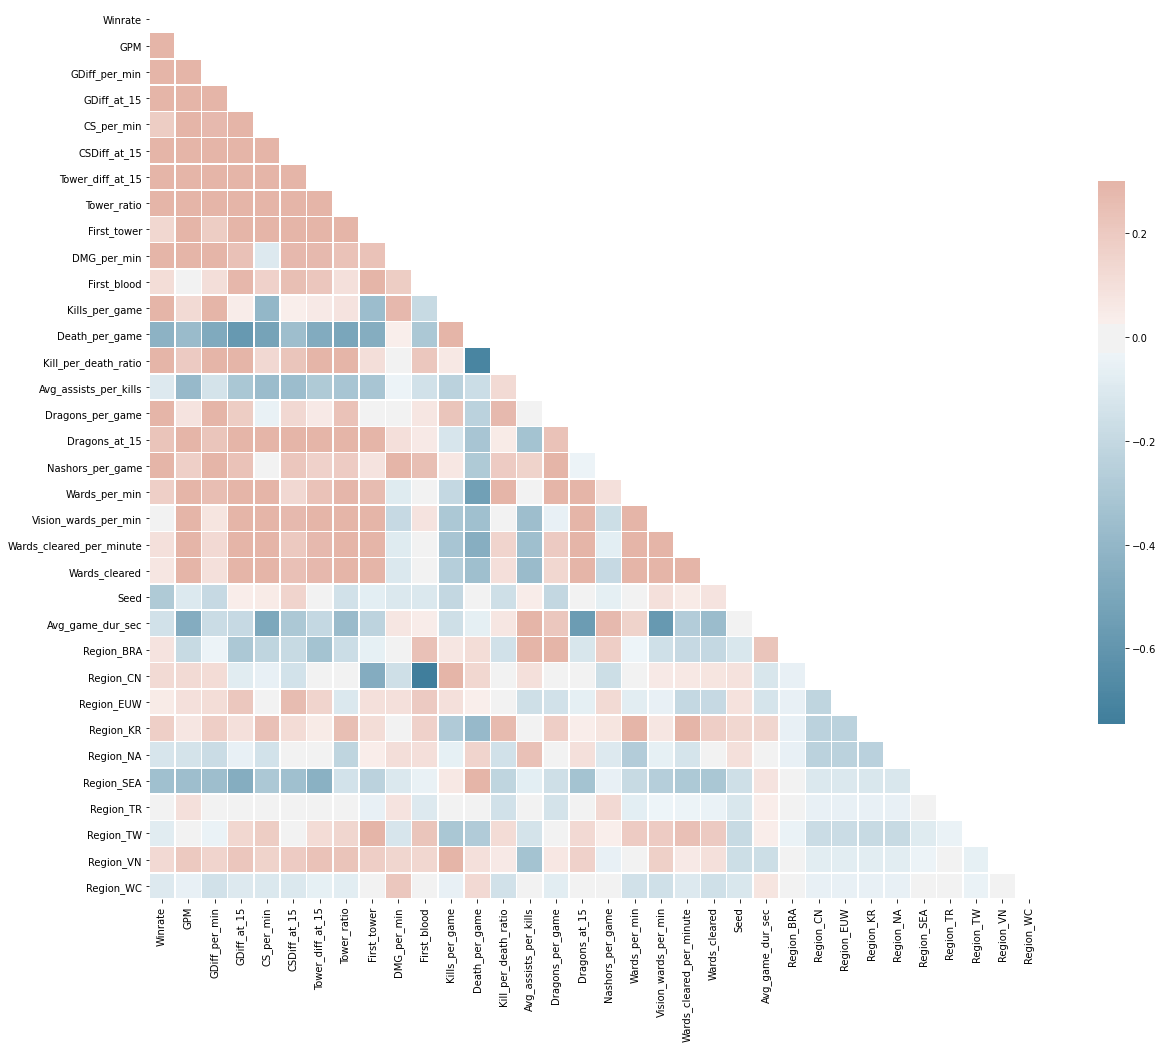

In [21]:
## plotting cross correlation matrix

correlation_matrix = clean_exog_vars.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
clean_exog_vars = raw_exog_vars.drop(columns = ["Death_per_game"])

### Handling the meta shift over years

In [23]:
avg_data_for_viz_1 = clean_train_test_w_R_dummies.groupby(by = ["Season" , "Got_out_of_group"]).mean().reset_index()
avg_data_for_viz_1_0 = avg_data_for_viz_1.loc[avg_data_for_viz_1["Got_out_of_group"] == 0]
avg_data_for_viz_1_1 = avg_data_for_viz_1.loc[avg_data_for_viz_1["Got_out_of_group"] == 1]
avg_data_for_viz_2 = clean_train_test_w_R_dummies.drop(columns = "Got_out_of_group").groupby(by = ["Season"]).mean().reset_index()
avg_data_for_viz_2.insert(loc = 1 , column = "Got_out_of_group" , value = "Avg")

In [24]:
avg_data_for_viz = pd.concat([avg_data_for_viz_1, avg_data_for_viz_2], axis = 0 )
avg_data_for_viz

,Season,Got_out_of_group,Winrate,GPM,GDiff_per_min,GDiff_at_15,CS_per_min,CSDiff_at_15,Tower_diff_at_15,Tower_ratio,...,Region_BRA,Region_CN,Region_EUW,Region_KR,Region_NA,Region_SEA,Region_TR,Region_TW,Region_VN,Region_WC
0,S5,0,0.557500,1648.7500,29.250000,-1220.875000,27.437500,-13.225000,-0.513750,2.075000,...,0.1250,0.250000,0.125000,0.000000,0.375000,0.1250,0.0000,0.000000,0.0000,0.000000
1,S5,1,0.666250,1706.7500,142.375000,413.875000,28.737500,4.200000,0.122500,2.550000,...,0.0000,0.125000,0.250000,0.375000,0.000000,0.2500,0.0000,0.000000,0.0000,0.000000
2,S6,0,0.660000,1845.0000,133.000000,1038.200000,30.680000,7.820000,0.410000,2.940000,...,0.0000,0.000000,0.200000,0.000000,0.400000,0.0000,0.0000,0.400000,0.0000,0.000000
3,S6,1,0.642500,1840.1250,112.500000,1.375000,30.400000,-0.212500,-0.017500,2.775000,...,0.0000,0.250000,0.125000,0.375000,0.125000,0.0000,0.0000,0.000000,0.0000,0.125000
4,S7,0,0.606250,1854.7500,100.625000,453.125000,32.050000,8.275000,0.327500,2.987500,...,0.0000,0.125000,0.125000,0.000000,0.250000,0.1250,0.1250,0.250000,0.0000,0.000000
5,S7,1,0.630000,1850.3750,107.875000,356.750000,32.325000,5.287500,0.127500,2.950000,...,0.0000,0.250000,0.250000,0.375000,0.125000,0.0000,0.0000,0.000000,0.0000,0.000000
6,S8,0,0.608750,1809.5000,86.375000,672.625000,33.962500,7.587500,0.315000,2.887500,...,0.0000,0.000000,0.125000,0.125000,0.250000,0.0000,0.0000,0.375000,0.1250,0.000000
7,S8,1,0.642500,1843.3750,131.125000,709.250000,34.537500,12.375000,0.423750,3.050000,...,0.0000,0.375000,0.250000,0.250000,0.125000,0.0000,0.0000,0.000000,0.0000,0.000000
8,S9,0,0.611250,1832.2500,79.250000,518.750000,32.687500,5.962500,0.202500,3.050000,...,0.0000,0.125000,0.000000,0.000000,0.375000,0.0000,0.0000,0.375000,0.1250,0.000000
9,S9,1,0.653750,1897.2500,136.875000,809.625000,33.462500,13.137500,0.177500,3.125000,...,0.0000,0.250000,0.375000,0.375000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000


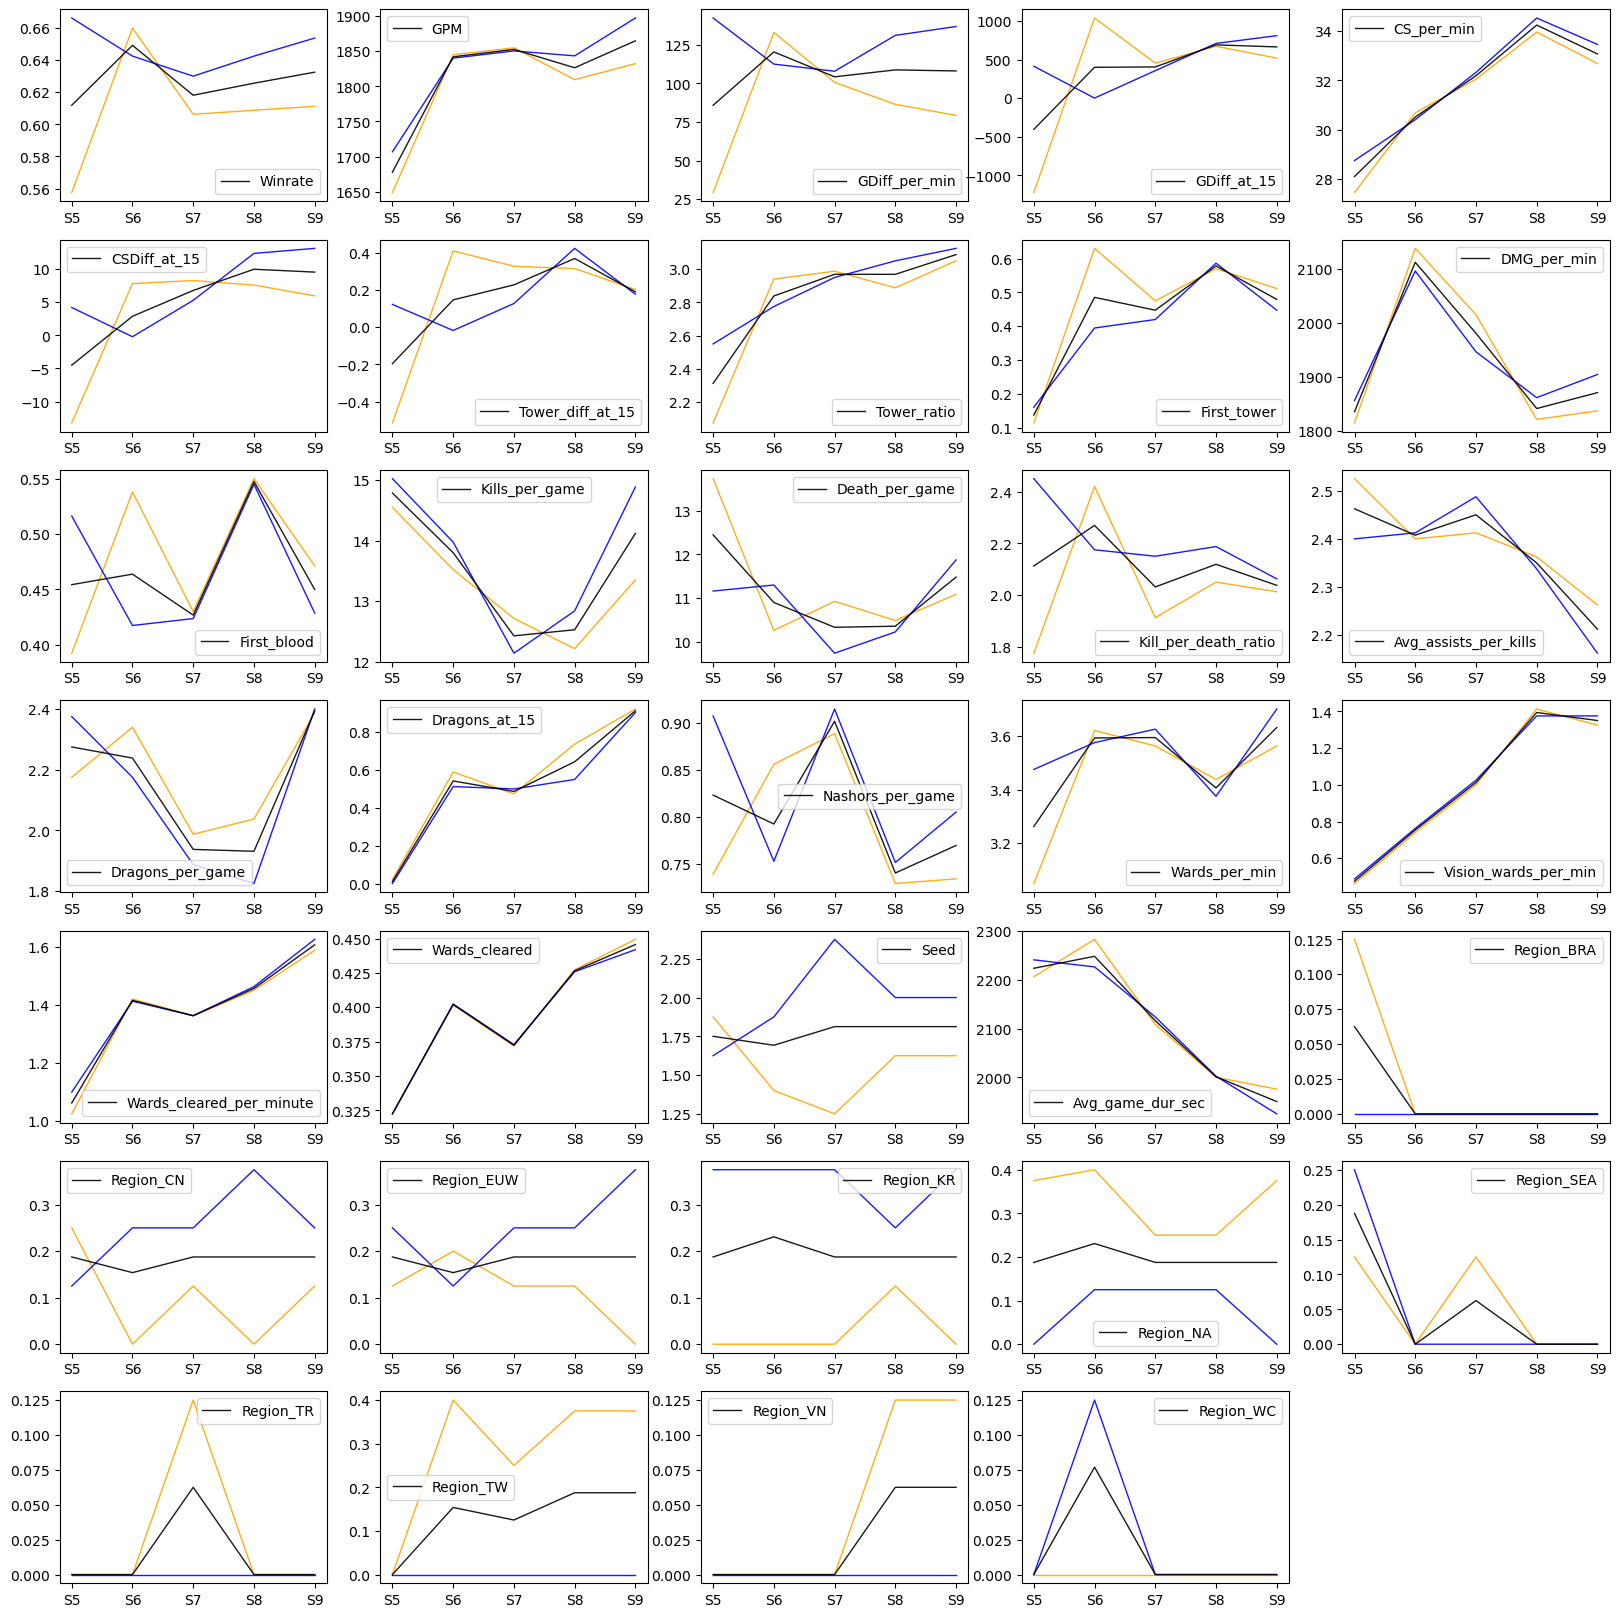

In [25]:
## Taking a look at trends over seasons 

fig = plt.figure(figsize=(20,30), dpi= 100, facecolor='w', edgecolor='k')

num = 0
for column in avg_data_for_viz_1.drop(['Season', 'Got_out_of_group', "Group_wins"], axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(10,5, num)
    
    # Plot the lineplot
    plt.plot(avg_data_for_viz_1_0['Season'], avg_data_for_viz_1_0[column], marker='', color="orange", linewidth=1, alpha=0.9)
    plt.plot(avg_data_for_viz_1_1['Season'], avg_data_for_viz_1_1[column], marker='', color="blue", linewidth=1, alpha=0.9 )
    plt.plot(avg_data_for_viz_2['Season'], avg_data_for_viz_2[column], marker='', color="black", linewidth=1, alpha=0.9, label=column)
    plt.legend()



    

We are looking for exog vars that are not fluctuating between teams that got out of the group and did not get out of the group over time

In [26]:
list_of_selected_vars = ["join_column",
                         "Winrate", 
                         "GPM", 
                         "CS_per_min" , 
                         "First_tower", 
                         "Kill_per_death_ratio" , 
                         "Dragons_at_15", 
                         "Wards_per_min" ,
                         "Wards_cleared_per_minute",
                         "Seed", 
                         "Avg_game_dur_sec" , 
                         "Region_BRA" , 
                         "Region_CN" , 
                         "Region_EUW" , 
                         "Region_KR" , 
                         "Region_NA", 
                         "Region_SEA" , 
                         "Region_TR", 
                         "Region_TW", 
                         "Region_VN" , 
                         "Region_WC", 
                         "Got_out_of_group", 
                         "Group_wins"]

final_train_test = clean_train_test_w_R_dummies[list_of_selected_vars]

final_train_test

,join_column,Winrate,GPM,CS_per_min,First_tower,Kill_per_death_ratio,Dragons_at_15,Wards_per_min,Wards_cleared_per_minute,Seed,...,Region_EUW,Region_KR,Region_NA,Region_SEA,Region_TR,Region_TW,Region_VN,Region_WC,Got_out_of_group,Group_wins
0,AHQ_eSportsS5,0.54,1642.0,27.7,0.23,1.3,0.00,3.5,1.1,2,...,0,0,0,1,0,0,0,0,1,3
1,Bangkok_TitansS5,0.38,1575.0,26.3,0.06,1.3,0.00,2.7,1.0,1,...,0,0,0,1,0,0,0,0,0,0
2,Cloud9S5,0.48,1637.0,27.8,0.08,2.0,0.00,2.8,1.1,1,...,0,0,1,0,0,0,0,0,0,3
3,Edward_GamingS5,0.67,1734.0,28.1,0.05,2.6,0.00,3.7,1.1,1,...,0,0,0,0,0,0,0,0,1,4
4,CLGS5,0.68,1694.0,27.2,0.13,2.1,0.00,2.9,1.1,2,...,0,0,1,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,GAM_EsportsS9,0.70,1900.0,32.9,0.60,2.5,0.70,3.3,1.4,1,...,0,0,0,0,0,0,1,0,0,1
73,DAMWON_GamingS9,0.64,1900.0,34.4,0.55,1.9,1.15,3.9,1.8,3,...,0,1,0,0,0,0,0,0,1,5
74,Clutch_GamingS9,0.53,1791.0,32.6,0.69,1.5,0.92,3.8,1.6,3,...,0,0,1,0,0,0,0,0,0,0
75,Hong_Kong_AttitudeS9,0.57,1841.0,33.5,0.53,2.0,0.74,3.5,1.5,1,...,0,0,0,0,0,1,0,0,0,0


In [27]:
final_train_test.describe()

,Winrate,GPM,CS_per_min,First_tower,Kill_per_death_ratio,Dragons_at_15,Wards_per_min,Wards_cleared_per_minute,Seed,Avg_game_dur_sec,...,Region_EUW,Region_KR,Region_NA,Region_SEA,Region_TR,Region_TW,Region_VN,Region_WC,Got_out_of_group,Group_wins
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,...,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.626623,1811.558442,31.664935,0.423377,2.107792,0.517013,3.493506,1.379221,1.779221,2102.350649,...,0.181818,0.194805,0.194805,0.051948,0.012987,0.129870,0.025974,0.012987,0.519481,3.064935
std,0.091416,87.655350,2.437091,0.216543,0.460196,0.338596,0.307938,0.223217,0.788459,160.760509,...,0.388224,0.398648,0.398648,0.223377,0.113961,0.338365,0.160101,0.113961,0.502897,1.558826
min,0.380000,1575.000000,26.300000,0.030000,1.100000,0.000000,2.700000,0.900000,1.000000,1776.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.570000,1772.000000,30.000000,0.220000,1.800000,0.360000,3.300000,1.200000,1.000000,1994.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.620000,1837.000000,32.000000,0.480000,2.100000,0.540000,3.500000,1.400000,2.000000,2101.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
75%,0.680000,1869.000000,33.100000,0.590000,2.400000,0.710000,3.700000,1.500000,2.000000,2175.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,0.880000,1955.000000,36.200000,0.860000,3.400000,1.330000,4.400000,1.900000,3.000000,2726.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


## Training the algorithms

### XGboost classifier for predict whether a team got out of the group or not (1 or 0)

In [28]:
### Separating exogs and labels

X, y = final_train_test.iloc[ : , 1 : 20] , final_train_test["Got_out_of_group"]

### Creating train and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state = 42)

In [29]:
## training with basic parameters for baseline model

model = xgb.XGBClassifier()
model.fit (X_train, y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
## accuracy for the training sample

y_pred_train = model.predict(X_train)
train_predictions_for_accuracy = [round(value) for value in y_pred_train]

accuracy = accuracy_score(y_train, train_predictions_for_accuracy)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [31]:
y_pred = model.predict(X_test)
test_predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.75%


In [32]:
## confusiom matrix for test sample

confusion_matrix(y_test, test_predictions)

array([[4, 1],
       [4, 7]], dtype=int64)

In [33]:
## hyperparameter tuning
    
### fixing learning rate and number of estimators for tree based parameter tuning

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
test_predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))  

Accuracy: 81.25%


In [34]:
## Tune max_depth and min_child_weight

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
              }

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators = 140, max_depth = 5,
 min_child_weight = 1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
 objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27), 
 param_grid = param_test1, scoring = 'roc_auc', n_jobs = 4, cv = 3)

gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 1}, 0.8234680134680136)

In [35]:
## Tune gamma

param_test2 = {
 'gamma': [i/10.0 for i in range(0,5)]
              }

gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators = 140, max_depth=5,
 min_child_weight = 1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
 objective = 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring = 'roc_auc',n_jobs = 4, cv = 3 )


gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.4}, 0.8268350168350168)

In [36]:
## Learning rate and number of trees

param_test3 = {
 'learning_rate': [0.001, 0.01, 0.1],
 'n_estimators' : [100, 250, 500, 1000, 5000]  
              }

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators = 140, max_depth=5,
 min_child_weight = 1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
 objective = 'binary:logistic', nthread = 4, scale_pos_weight=1,seed = 27), 
 param_grid = param_test3, scoring = 'roc_auc',n_jobs = 4, cv = 3 )


gsearch3.fit(X_train, y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.0543313 , 0.12067366, 0.24634647, 0.47827649, 2.2376833 ,
         0.05631955, 0.12666305, 0.23632542, 0.40939061, 1.58831191,
         0.04633784, 0.09699821, 0.15667566, 0.30800287, 1.1359086 ]),
  'std_fit_time': array([0.00124675, 0.00818508, 0.00329943, 0.01577401, 0.03210927,
         0.00401229, 0.00340191, 0.00901022, 0.0252228 , 0.06387932,
         0.00169445, 0.00535605, 0.0054364 , 0.01218443, 0.09093983]),
  'mean_score_time': array([0.00599623, 0.00599655, 0.00599631, 0.00632985, 0.00932837,
         0.00599655, 0.00633001, 0.00633001, 0.0063297 , 0.00799545,
         0.00632596, 0.00599662, 0.00566355, 0.00632985, 0.00699631]),
  'std_score_time': array([3.37174788e-07, 7.86741172e-07, 2.97360213e-07, 4.71314248e-04,
         4.71538951e-04, 2.97360213e-07, 4.70864682e-04, 4.71539192e-04,
         4.71089385e-04, 4.05233662e-07, 4.66144155e-04, 1.12391596e-07,
         4.70977074e-04, 4.71145571e-04, 8.16145448e-04]),
  'param_learning_rate': 

In [37]:
## final model

xgb_final = XGBClassifier(
                 learning_rate = 0.01,
                 n_estimators = 250,
                 max_depth = 5,
                 min_child_weight = 1,
                 gamma = 0.4,
                 subsample = 0.8,
                 colsample_bytree = 0.8,
                 objective = 'binary:logistic',
                 nthread = 4,
                 scale_pos_weight = 1,
                 seed = 27)

xgb_final.fit(X_train, y_train)
y_pred = xgb_final.predict(X_test)
test_predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 62.50%


The model overfited on the train data, therefore I am going to use the model chosen after the baseline model. This can be caused by the small amount fo data

In [38]:
xgb_final_2 = XGBClassifier(
                 learning_rate = 0.1,
                 n_estimators = 1000,
                 max_depth = 5,
                 min_child_weight = 1,
                 gamma = 0,
                 subsample = 0.8,
                 colsample_bytree = 0.8,
                 objective = 'binary:logistic',
                 nthread = 4,
                 scale_pos_weight = 1,
                 seed = 27)

xgb_final_2.fit(X_train, y_train)
y_pred = xgb_final_2.predict(X_test)
test_predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.25%


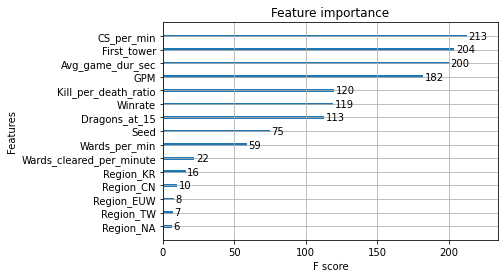

In [39]:
xgb.plot_importance(xgb_final_2)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

### XGboost regressor for predict wins in groups

In [40]:
### Separating exogs and labels

X, y = final_train_test.iloc[ : , 1 : 20] , final_train_test["Group_wins"]

### Creating train and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state = 42)

In [41]:
### Baseline model for wins with defualt parameters

xg_reg = xgb.XGBRegressor()

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [42]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1.475098


In [43]:
### Using new parameters

xg_reg_1 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, alpha = 10, gamma = 0, n_estimators = 1000)

xg_reg_1.fit(X_train,y_train)

preds = xg_reg_1.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1.336104


That's not really impressive. Let's try elastic net regression to predict wins

### Elastic net regressor for predict wins in groups

In [44]:
## Optimizing alpha value for elastic net regressor

elastic = ElasticNet (normalize = True)
e_net_search = GridSearchCV (estimator = elastic, 
                      param_grid = {'alpha': np.arange(0 , 1, 0.01), 'l1_ratio': np.arange(0 , 1, 0.01)}, 
                      scoring = 'neg_mean_squared_error',
                      n_jobs = 1,
                      refit = True,
                      cv = 3)

e_net_search.fit(X_train, y_train)
e_net_search.best_params_

warnings.filterwarnings('ignore')

In [45]:
## further tuning the hyperparameters

e_net_search_2 = GridSearchCV (estimator = elastic, 
                      param_grid = {'alpha': np.arange(0 , 0.02, 0.001), 'l1_ratio': np.arange(0.99 , 1, 0.001)}, 
                      scoring = 'neg_mean_squared_error',
                      n_jobs = 1,
                      refit = True,
                      cv = 3 )

e_net_search_2.fit(X_train,y_train)
e_net_search_2.best_params_

warnings.filterwarnings('ignore')

In [46]:
## Using the final model

elastic = ElasticNet(normalize = True, alpha = 0.01, l1_ratio = 1)
elastic.fit(X_train,y_train)

mean_squared_error(y_true=y_test, y_pred=elastic.predict(X_test))

1.9718575594955863

The xgboost regressor works better, than elastic net regressor, therefore, we are going to use that for predictions in wins too

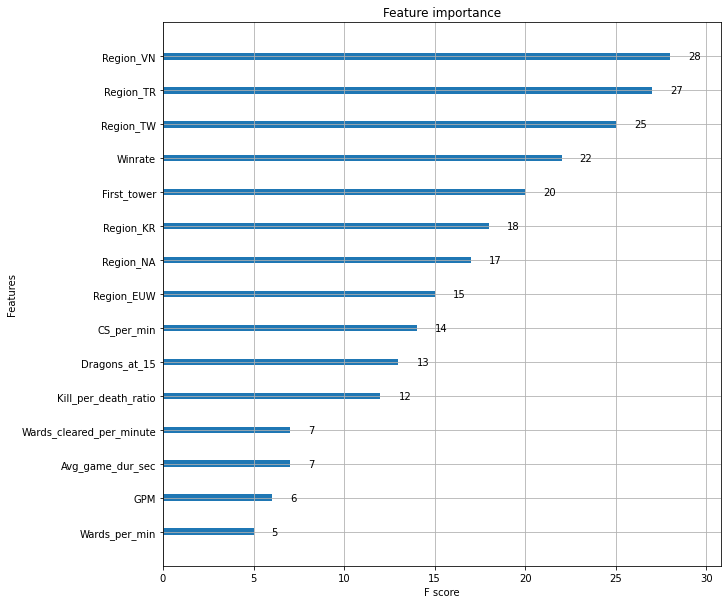

In [47]:
xgb.plot_importance(xg_reg_1)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

## Prediction

In [48]:
url_df_pred = pd.read_csv("s10_predict.csv", sep = ";")

In [49]:
url_df_pred

,Team,Season,Seed,Gol_code,Group
0,Top_esports,S10,1,829,D
1,JD_Gaming,S10,2,836,B
2,Suning,S10,3,834,A
3,G2_Esports,S10,1,891,A
4,Fnatic,S10,2,890,C
5,Rogue,S10,3,895,B
6,DAMWON_Gaming,S10,1,849,B
7,DRX,S10,2,853,D
8,Gen.G,S10,3,852,C
9,TSM,S10,1,877,C


In [50]:
pred_raw = gol_scraper(url_df_pred, "Gol_code")

In [51]:
pred_raw.isnull().sum()

Team                        0
Region                      0
Season                      0
Winrate                     0
Avg_game_dur                0
GPM                         0
GDiff_per_min               0
GDiff_at_15                 0
CS_per_min                  0
CSDiff_at_15                0
Tower_diff_at_15            0
Tower_ratio                 0
First_tower                 0
DMG_per_min                 0
First_blood                 0
Kills_per_game              0
Death_per_game              0
Kill_per_death_ratio        0
Avg_assists_per_kills       0
Dragons_per_game            0
Dragons_at_15               0
Nashors_per_game            0
Wards_per_min               0
Vision_wards_per_min        0
Wards_cleared_per_minute    0
Wards_cleared               0
dtype: int64

In [52]:
pred_raw

,Team,Region,Season,Winrate,Avg_game_dur,GPM,GDiff_per_min,GDiff_at_15,CS_per_min,CSDiff_at_15,...,Death_per_game,Kill_per_death_ratio,Avg_assists_per_kills,Dragons_per_game,Dragons_at_15,Nashors_per_game,Wards_per_min,Vision_wards_per_min,Wards_cleared_per_minute,Wards_cleared
0,Top_esports,CN,S10,73,32:21,1877,+171,+665,32.8,+16,...,12.1,2,2.4,2.6,0.96,0.89,3.2,1.3,1.7,50.4
1,JD_Gaming,CN,S10,69,32:03,1861,+139,+403,33.5,+7,...,11.3,2.1,2.3,2.5,0.71,0.79,3.3,1.2,1.6,47.7
2,Suning,CN,S10,62,33:02,1795,+82,+445,31.9,+16.2,...,12.4,1.5,2.3,2.5,0.73,0.93,3.7,1.3,1.5,45
3,G2_Esports,EUW,S10,63,32:56,1824,+67,+459,32.7,+13.6,...,13.7,1.7,2.1,2.6,1.03,0.57,3.4,1.4,1.4,43.9
4,Fnatic,EUW,S10,52,33:41,1816,+20,+205,33,+5.9,...,15.4,1.2,2.2,2.3,0.72,0.69,3.1,1.2,1.4,41
5,Rogue,EUW,S10,62,33:39,1798,+90,+860,32,-5.5,...,9.4,2.1,2.2,2.6,0.9,0.79,3,1.1,1.3,39.8
6,DAMWON_Gaming,KR,S10,88,28:20,1988,+383,+2956,34.7,+30.7,...,7.5,2.9,2.2,2.5,0.9,0.74,3.5,1.3,1.6,48
7,DRX,KR,S10,66,32:20,1855,+126,+731,35.1,+29.3,...,11.8,1.8,2.4,2.3,0.76,0.76,3.6,1.3,1.7,47.2
8,Gen.G,KR,S10,72,31:03,1892,+197,+1321,34,+15.7,...,9.7,2.3,2.1,3.2,1.27,0.71,3.7,1.5,1.8,50.1
9,TSM,NA,S10,63,34:48,1794,+86,+211,33,+3.9,...,9.9,2.1,2.4,2.7,0.95,0.84,3.4,1.3,1.4,43.1


In [53]:
pred_raw["join_column"] = pred_raw["Team"] + pred_raw["Season"]
url_df_pred["join_column"] = url_df_pred["Team"] + url_df_pred["Season"]
seeds = url_df_pred[["join_column", "Seed"]]

pred_raw_w_seeds = pred_raw.merge(group_results, how = "left" , on = "join_column")

## Puting the variables in the correct format

## Creating AVG game duration in secs

pred_raw_w_seeds['Avg_game_dur_min_part'], pred_raw_w_seeds['Avg_game_dur_sec_part'] = pred_raw_w_seeds['Avg_game_dur'].str.split(':', 1).str
pred_raw_w_seeds['Avg_game_dur_sec'] = pred_raw_w_seeds['Avg_game_dur_min_part'].astype("int") * 60 + pred_raw_w_seeds['Avg_game_dur_sec_part'].astype("int")

## Turning originally % variabes to values between 0-1

clean_pred = pred_raw_w_seeds.copy()
clean_pred["Winrate"] = clean_pred["Winrate"].astype("float") / 100
clean_pred["First_tower"] = clean_pred["First_tower"].astype("float") / 100
clean_pred["First_blood"] = clean_pred["First_blood"].astype("float") / 100
clean_pred["Wards_cleared"] = clean_pred["Wards_cleared"].astype("float") / 100

## Turning variables into proper format

clean_pred["GPM"] = clean_pred["GPM"].astype("float")
clean_pred["GDiff_per_min"] = clean_pred["GDiff_per_min"].astype("float")
clean_pred["GDiff_at_15"] = clean_pred["GDiff_at_15"].astype("float")
clean_pred["CS_per_min"] = clean_pred["CS_per_min"].astype("float")
clean_pred["CSDiff_at_15"] = clean_pred["CSDiff_at_15"].astype("float")
clean_pred["Tower_diff_at_15"] = clean_pred["Tower_diff_at_15"].astype("float")
clean_pred["Tower_ratio"] = clean_pred["Tower_ratio"].astype("float")
clean_pred["DMG_per_min"] = clean_pred["DMG_per_min"].astype("float")
clean_pred["Kills_per_game"] = clean_pred["Kills_per_game"].astype("float")
clean_pred["Death_per_game"] = clean_pred["Death_per_game"].astype("float")
clean_pred["Kill_per_death_ratio"] = clean_pred["Kill_per_death_ratio"].astype("float")
clean_pred["Avg_assists_per_kills"] = clean_pred["Avg_assists_per_kills"].astype("float")
clean_pred["Dragons_per_game"] = clean_pred["Dragons_per_game"].astype("float")
clean_pred["Dragons_at_15"] = clean_pred["Dragons_at_15"].astype("float")
clean_pred["Nashors_per_game"] = clean_pred["Nashors_per_game"].astype("float")
clean_pred["Wards_per_min"] = clean_pred["Wards_per_min"].astype("float")
clean_pred["Vision_wards_per_min"] = clean_pred["Vision_wards_per_min"].astype("float")
clean_pred["Wards_cleared_per_minute"] = clean_pred["Wards_cleared_per_minute"].astype("float")

## One-hot encoding Regions

clean_pred_w_R_dummies = pd.concat([clean_pred , pd.get_dummies(clean_pred.Region , prefix = "Region")] , axis = 1)

In [54]:
clean_pred_w_R_dummies

,Team,Region,Season,Winrate,Avg_game_dur,GPM,GDiff_per_min,GDiff_at_15,CS_per_min,CSDiff_at_15,...,Group_wins,Avg_game_dur_min_part,Avg_game_dur_sec_part,Avg_game_dur_sec,Region_CIS,Region_CN,Region_EUW,Region_KR,Region_NA,Region_PCS
0,Top_esports,CN,S10,0.73,32:21,1877.0,171.0,665.0,32.8,16.0,...,NaN,32,21,1941,0,1,0,0,0,0
1,JD_Gaming,CN,S10,0.69,32:03,1861.0,139.0,403.0,33.5,7.0,...,NaN,32,03,1923,0,1,0,0,0,0
2,Suning,CN,S10,0.62,33:02,1795.0,82.0,445.0,31.9,16.2,...,NaN,33,02,1982,0,1,0,0,0,0
3,G2_Esports,EUW,S10,0.63,32:56,1824.0,67.0,459.0,32.7,13.6,...,NaN,32,56,1976,0,0,1,0,0,0
4,Fnatic,EUW,S10,0.52,33:41,1816.0,20.0,205.0,33.0,5.9,...,NaN,33,41,2021,0,0,1,0,0,0
5,Rogue,EUW,S10,0.62,33:39,1798.0,90.0,860.0,32.0,-5.5,...,NaN,33,39,2019,0,0,1,0,0,0
6,DAMWON_Gaming,KR,S10,0.88,28:20,1988.0,383.0,2956.0,34.7,30.7,...,NaN,28,20,1700,0,0,0,1,0,0
7,DRX,KR,S10,0.66,32:20,1855.0,126.0,731.0,35.1,29.3,...,NaN,32,20,1940,0,0,0,1,0,0
8,Gen.G,KR,S10,0.72,31:03,1892.0,197.0,1321.0,34.0,15.7,...,NaN,31,03,1863,0,0,0,1,0,0
9,TSM,NA,S10,0.63,34:48,1794.0,86.0,211.0,33.0,3.9,...,NaN,34,48,2088,0,0,0,0,1,0


In [55]:
## handling regions

clean_pred_w_R_dummies["Region_WC"] = 0
clean_pred_w_R_dummies["Region_WC"][clean_pred_w_R_dummies.Region_CIS == 1] = 1

clean_pred_w_R_dummies["Region_TW"] = 0
clean_pred_w_R_dummies["Region_TW"][clean_pred_w_R_dummies.Region_PCS == 1] = 1

clean_pred_w_R_dummies["Region_TR"] = 0
clean_pred_w_R_dummies["Region_SEA"] = 0
clean_pred_w_R_dummies["Region_BRA"] = 0
clean_pred_w_R_dummies["Region_VN"] = 0

warnings.filterwarnings('ignore')

In [56]:
## Select vars

list_of_selected_vars = ["Winrate", 
                         "GPM", 
                         "CS_per_min" , 
                         "First_tower", 
                         "Kill_per_death_ratio" , 
                         "Dragons_at_15", 
                         "Wards_per_min" ,
                         "Wards_cleared_per_minute",
                         "Seed", 
                         "Avg_game_dur_sec" , 
                         "Region_BRA" , 
                         "Region_CN" , 
                         "Region_EUW" , 
                         "Region_KR" , 
                         "Region_NA", 
                         "Region_SEA" , 
                         "Region_TR", 
                         "Region_TW", 
                         "Region_VN"]

final_pred = clean_pred_w_R_dummies[list_of_selected_vars]

final_pred

,Winrate,GPM,CS_per_min,First_tower,Kill_per_death_ratio,Dragons_at_15,Wards_per_min,Wards_cleared_per_minute,Seed,Avg_game_dur_sec,Region_BRA,Region_CN,Region_EUW,Region_KR,Region_NA,Region_SEA,Region_TR,Region_TW,Region_VN
0,0.73,1877.0,32.8,0.51,2.0,0.96,3.2,1.7,NaN,1941,0,1,0,0,0,0,0,0,0
1,0.69,1861.0,33.5,0.46,2.1,0.71,3.3,1.6,NaN,1923,0,1,0,0,0,0,0,0,0
2,0.62,1795.0,31.9,0.56,1.5,0.73,3.7,1.5,NaN,1982,0,1,0,0,0,0,0,0,0
3,0.63,1824.0,32.7,0.51,1.7,1.03,3.4,1.4,NaN,1976,0,0,1,0,0,0,0,0,0
4,0.52,1816.0,33.0,0.38,1.2,0.72,3.1,1.4,NaN,2021,0,0,1,0,0,0,0,0,0
5,0.62,1798.0,32.0,0.76,2.1,0.90,3.0,1.3,NaN,2019,0,0,1,0,0,0,0,0,0
6,0.88,1988.0,34.7,0.90,2.9,0.90,3.5,1.6,NaN,1700,0,0,0,1,0,0,0,0,0
7,0.66,1855.0,35.1,0.42,1.8,0.76,3.6,1.7,NaN,1940,0,0,0,1,0,0,0,0,0
8,0.72,1892.0,34.0,0.69,2.3,1.27,3.7,1.8,NaN,1863,0,0,0,1,0,0,0,0,0
9,0.63,1794.0,33.0,0.63,2.1,0.95,3.4,1.4,NaN,2088,0,0,0,0,1,0,0,0,0


In [57]:
final_pred_gog = xgb_final_2.predict(final_pred)
final_pred_gwins = xg_reg_1.predict(final_pred)

In [58]:
url_df_pred["final_pred_gog"] = final_pred_gog
url_df_pred["final_pred_gwins"] = final_pred_gwins

In [59]:
url_df_pred_sorted = url_df_pred.sort_values(by = ["Group" , "final_pred_gog" , "final_pred_gwins"], ascending = (True, False, False))

In [60]:
url_df_pred_sorted

,Team,Season,Seed,Gol_code,Group,join_column,final_pred_gog,final_pred_gwins
2,Suning,S10,3,834,A,SuningS10,0,3.465758
3,G2_Esports,S10,1,891,A,G2_EsportsS10,0,3.175542
13,Team_Liquid,S10,3,876,A,Team_LiquidS10,0,3.166782
11,Machi_Esports,S10,1,976,A,Machi_EsportsS10,0,2.249195
6,DAMWON_Gaming,S10,1,849,B,DAMWON_GamingS10,1,4.120141
1,JD_Gaming,S10,2,836,B,JD_GamingS10,1,3.957377
5,Rogue,S10,3,895,B,RogueS10,0,3.109638
12,PSG_Talon,S10,1,982,B,PSG_TalonS10,0,2.234909
8,Gen.G,S10,3,852,C,Gen.GS10,0,4.103996
14,LGD_Gaming,S10,4,840,C,LGD_GamingS10,0,3.465758


Since only 2 teams were predicted to make it out of groups, we will consider the number of wins as the deciding factor

In [61]:
results = url_df_pred[["Group" , "Team" , "final_pred_gwins"]]